In [1]:
import numpy as np
from functools import partial
from scipy.stats import qmc

class RADE:
    def __init__(
            self,
            system_equation,
            boundaries,
            population_size,
            max_generation,
            number_per_subpopulation,
            theta,
            tau_d,
            F_init,
            CR_init,
            max_archive_size,
            max_memories_size,
            beta = 100,
            rho = 1e-8,
            seed = None
            ) -> None:
        """
        PROPERTIES
            archive: list= list of eligible roots
            systemeq: func= systen of equation in question
            boundaries: np.ndarray= boundaries/constraint of the problem
            dim: int= dimension of roots
            population_size: int= population size per generation
            max_generation: int= maximal iteration
            max_memories_size: int=  maximum memories size
            memories_F: np.ndarray= memories of scaling factor
            memories_CR: np.ndarray= memories of crossover rate
            number_per_subpopulation: int= number of individuals in a subpopulation of the target individu
            theta: the error of the objective function
            tau_d: the minimum distance between roots
            max_archive_size: maximum found roots
            beta: int= large constant to control the penalty scale
            rho: float= small constant to adjust the radius of the repulsion regions
            seed: int= random state
        """
        self.boundaries = boundaries
        self.systemeq = system_equation
        self.population_size = population_size
        self.max_generation = max_generation
        self.number_per_subpopulation = number_per_subpopulation
        self.tau_d = tau_d
        self.max_archive_size = max_archive_size
        self.theta = theta
        self.seed = seed
        self.dim = boundaries.shape[0]
        self.archive = []
        self.max_memories_size = max_memories_size
        self.memories_F = np.ones(max_memories_size)*F_init
        self.memories_CR = np.ones(max_memories_size)*CR_init
        self.beta = beta
        self.rho = rho
        return None
    
    def objective_function(self,x:np.ndarray):
        res = 0
        F_array = self.systemeq(x)
        for f in F_array:
            res += np.abs(f)
        return -1/(1+res)
    
    # def objective_function(self,x:np.ndarray):
    #     res = 0
    #     F_array = self.systemeq(x)
    #     for f in F_array:
    #         res +=(f)**2
    #     return res

    def chi_p(self, delta_j, rho):
        """
        Characteristic Function
        """
        return 1 if delta_j <= rho else 0
    
    def repulsion_function(
            self,
            x):
        """
        Repulsion Function
        """
        f_x = self.objective_function(x)
        Rx = 0
        for x_star in self.archive:
            delta_j = np.linalg.norm(x-x_star)
            Rx += np.exp(-delta_j) * self.chi_p(delta_j, self.rho)
        Rx *= self.beta
        Rx += f_x
        return Rx
    
    def fitness_function(
            self,
            x
            ):
        """
        Fitness Function
        """
        if self.archive == []:
            return self.objective_function(x)
        else:
            return self.repulsion_function(x)
        
        """GENERATE POINTS USING SOBOL SEQUENCE"""
    def generate_points(
            self,
            npoint: int, 
            low=-10, 
            high=10, 
            sobol=True
            ):
        """
                Generates points within the specified bounds.

            Args:
                dim: Number of dimensions.
                npoint: Number of points to generate.
                low: Lower bound for each variable (scalar or list/numpy array).
                high: Upper bound for each variable (scalar or list/numpy array).
                sobol: Flag indicating whether to use Sobol sequence (True) or random sampling (False).

            Returns:
                A numpy array of size (npoint, dim) representing the generated points.
        """

        if type(low) != type(high):
            raise TypeError('The type of "low" and "high" should be the same.')

        # Handle boundaries
        if type(low) == int:
            boundaries = [(low, high) for _ in range(self.dim)]
        elif type(low) in (list, np.ndarray):
            if len(low) != len(high):
                raise TypeError('The length of "low" and "high" should be the same.')
            else:
                boundaries = [(low[i], high[i]) for i in range(len(low))]

        # Generate points based on the sobol flag
        if sobol:
            sampler = qmc.Sobol(d=self.dim,scramble=True,seed=self.seed)
            sample = sampler.random(n=npoint)
            scaled_points = qmc.scale(sample=sample,l_bounds=low,u_bounds=high)

        else:
            # Generate random points
            np.random.seed(self.seed)
            scaled_points = np.zeros((npoint, self.dim))
            for i in range(self.dim):
                min_val, max_val = boundaries[i]
                scaled_points[:, i] = np.random.uniform(min_val, max_val, npoint)

        return scaled_points
    
    def mutate(self,population, F):
        """
        Mutation function for DE
        """
        # Vectorized mutation operation
        indices = np.arange(population.shape[0])
        np.random.shuffle(indices)
        r1, r2, r3 = population[indices[:3]]
        mutant = r1 + F * (r2 - r3)
        return mutant
    
    def crossover(self, target, mutant, CR):
        cross_points = np.random.random(target.shape) < CR
        # Ensure at least one true crossover point
        if not np.any(cross_points):
            cross_points[np.random.randint(0, target.shape[0])] = True
        trial = np.where(cross_points, mutant, target)
        return trial
    
    def mutation_penalty(
            self,
            x_i, 
            subpop_i, 
            boundaries, 
            scaling_factor
            ):
        """
        INPUT:
            x_i: np.ndarray= target x_i
            subpop_i: np.ndarray= number of individuals closest to x_i
            boundaries: np.ndarray= boundaries/constraints of the function
            scaling_factor: scaling factor of the function

        OUTPUT:
            dv_i: np.ndarray= donor vector that has been mutated and penalized.
        """

        """Generate three distinct individuals xr1, xr1, xr1 from the current population randomly"""
        subpop_i_copy = subpop_i.copy()
        pop_ids = np.arange(subpop_i_copy.shape[0])
        indices_to_delete = np.where(np.all(subpop_i_copy == x_i, axis=1))[0] # Ensure that x_i is excluded from the selected subpopulation
        subpop_ids_no_i = np.delete(pop_ids, indices_to_delete, axis=0)
        subpop_i_copy = subpop_i_copy[subpop_ids_no_i]

        """Mutation form the donor/mutation vector"""
        dv_i = self.mutate(subpop_i_copy,scaling_factor)

        """Set penalty for every donor vector that violates the boundaries"""
        for j in range (len(dv_i)):
            if dv_i[j] < boundaries[j,0]:
                dv_i[j] = (x_i[j]+boundaries[j,0])/2
            elif dv_i[j] > boundaries[j,1]:
                dv_i[j] = (x_i[j]+boundaries[j,1])/2
        return dv_i
    
    def subpopulating(
            self,
            individual, 
            population, 
            t,
            return_index = False,
            show_distances = False
            ): 
        """
        Calculate Euclidean distances and select t closest individuals.
        INPUT:
            individual: np.ndarray= individual target
            population: np.ndarray= population where the target in
            t: int= max number of units in a subpopulation

        OUTPUT:
            closest_indices: np.ndarray= array of closest index of the target individual
            subpop: np.ndarray= array of closest individuals of the target individual
        """
        
        """Calculate the Euclidean distances from the individual to all others in the population"""
        distances = np.sqrt(np.sum((population - individual) ** 2, axis=1))

        # Get the indices of the individuals with the smallest distances
        closest_indices = np.argsort(distances)[:t]
        # Form the subpopulation with the closest individuals
        subpop = population[closest_indices]

        if show_distances == True:
            print(f'Distance: \n{distances[:t]}')
        if return_index == True:
            if t == 1:
                return closest_indices,subpop.flatten()
            else:
                return closest_indices,subpop
        else:
            if t == 1:
                return subpop.flatten()
            else:
                return subpop
            
    def update_archive(
            self,
            x: np.ndarray
            ):
        """
        INPUT:
            x: list= Individual

        OUTPUT: 
            archive: list= updated archive
        """

        f_x = self.objective_function(x)
        s = len(self.archive) # archive current size
        if f_x < self.theta: # x is a root
            # print(f'f({x})= {f_x}')
            if s == 0: # archive is empty
                self.archive.append(x)
                s+=1
            else:
                """Find the closest solution x_prime ∈ archive to x in the decision space"""
                dist_list = [np.linalg.norm(d) for d in x - self.archive]
                idx_min = np.argmin(dist_list)
                dist_min = dist_list[idx_min]
                x_prime = self.archive[idx_min]
                f_x_prime = self.objective_function(x_prime)
                if dist_min < self.tau_d: # x and x_prime are too close
                    if f_x < f_x_prime:
                        x_prime = x
                        self.archive[idx_min] = x_prime
                else:
                    if s < self.max_archive_size:
                        self.archive.append(x)
                        s += 1
                    else:       # archive is full
                        if f_x<f_x_prime:
                            x_prime = x
                            self.archive[idx_min] = x_prime
    
    def update_parameter(self):
        """
        OUTPUT
            Fi: float= scaling factor
            CRi: float= crossover rate
        """
        # Randomly select an index
        hi = np.random.randint(0, self.max_memories_size)
        # Generate Fi using the Cauchy distribution with the location parameter MF[hi] and scale 0.1
        Fi = np.random.standard_cauchy() * 0.1 + self.memories_F[hi]
        # Generate CRi using the Gaussian distribution with mean MCR[hi] and standard deviation 0.1
        CRi = np.random.normal(self.memories_CR[hi], 0.1)
        # Ensure CRi is within the range [0, 1] and Fi is within the range [0,2]
        Fi = np.clip(Fi, 0, 1)
        CRi = np.clip(CRi, 0, 1)
        return Fi, CRi
    
    def meanWL(self, elements, weights):
        """
        Calculate the weighted Lehmer mean of elements.
        Lehmer mean is calculated as the weighted sum of the squares
        divided by the weighted sum of the elements.
        """
        numerator = np.sum(np.multiply(np.square(elements), weights))
        denominator = np.sum(np.multiply(elements, weights))
        return numerator / denominator if denominator != 0 else 0
    
    # Define the weighted arithmetic mean function
    def meanWA(self, elements, weights):
        """
        Calculate the weighted arithmetic mean of elements.
        This is the standard weighted mean.
        """
        return np.average(elements, weights=weights)
    
    def update_history(
            self,
            S_F,
            S_CR,
            k
            ):
        weights = np.array([1 for _ in range (len(S_F))])
        if len(S_F)!=0:
            self.memories_F[k] = self.meanWL(S_F,weights) 
        if len(S_CR)!=0:
            self.memories_CR[k] = self.meanWA(S_CR,weights)
    
    def RADE_evaluation(
            self,
            print_gen = False,
            root_history = False
            ):
        """
        OUTPUT
            best: np.ndarray= best individual in term of objective function
            fitness[best_idx]: np.ndarray= best value of objective function
            archive: roots found in the problem
        """
        np.random.seed(self.seed)
        population = self.generate_points(
            npoint=self.population_size,
            low=self.boundaries[:,0],
            high=self.boundaries[:,1],
            sobol=True)
        fitness = np.asarray([self.objective_function(ind) for ind in population])
        best_idx = np.argmin(fitness)
        best = population[best_idx] # objective function must be minimizing
        subpop = np.array([self.subpopulating(individual=xi, population=population, t=self.number_per_subpopulation) for xi in population])

        k=0
        if root_history == True:
            history_root = {}
        for gen in range(self.max_generation):
            S_F, S_CR = [],[]
            for i in range(self.population_size):
                F_i,CR_i = self.update_parameter()
                x_i = population[i]
                mutant = self.mutation_penalty(
                    x_i=x_i,
                    subpop_i=subpop[i],
                    boundaries=self.boundaries,
                    scaling_factor=F_i)
                trial = self.crossover(target=population[i], mutant=mutant, CR=CR_i)
                trial_fitness = self.fitness_function(x=trial)
                
                if trial_fitness < fitness[i]:
                    fitness[i] = trial_fitness
                    population[i] = trial
                    self.update_archive(x=trial)
                    S_F.append(F_i)
                    S_CR.append(CR_i)
                    if trial_fitness < fitness[best_idx]:
                        best_idx = i
                        best = trial

            if print_gen == True:
                print(f"=========Generation {gen}=========")
                # print(f"Best Fitness: {fitness[best_idx]}")
                print(f'Archive:{self.archive}')
            
            if root_history == True:
                history_root[gen] = self.archive.copy()
            
                # print(f'S_F: {S_F}\nS_CR: {S_CR}')
            """Update parameter history"""
            if (len(S_F)!=0) & (len(S_CR)!=0):
                self.update_history(S_F=S_F,S_CR=S_CR,k=k)
                # print(f'M_F: {M_F}\nM_CR: {M_CR}')
                k +=1
                if k >= self.max_memories_size:
                    k = 1

        
        if root_history == True:
            return best, fitness[best_idx], self.archive, history_root
        else:
            return best, fitness[best_idx], self.archive

In [2]:
dim = 2
boundaries = np.array([(-10,10) for _ in range (dim)])
pop_size=200
max_gen=1000
F_init=0.5
CR_init=0.5
num_l=20
theta=-1+1e-2
tau_d=0.4
s_max=100
print_gen=True
Hm = 50


def system_equations(x):
    f1 = np.exp(x[0]-x[1])-np.sin(x[0]+x[1])
    f2 = (x[0]*x[1])**2-np.cos(x[0]+x[1])
    return np.array([f1,f2])


seed = np.random.randint(0,100)
seed

7

In [3]:
Radeopt = RADE(
    system_equation=system_equations,
    boundaries=boundaries,
    population_size=pop_size,
    max_generation=max_gen,
    number_per_subpopulation=num_l,
    theta=theta,
    tau_d=tau_d,
    F_init=F_init,
    CR_init=CR_init,
    max_archive_size=s_max,
    max_memories_size=Hm,
    seed=seed
)

Radeopt.RADE_evaluation(print_gen=True,root_history=False)

c:\Users\ACER\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\_qmc.py:763: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


=========Generation 0=========
Archive:[]
=========Generation 1=========
Archive:[]
=========Generation 2=========
Archive:[]
=========Generation 3=========
Archive:[]
=========Generation 4=========
Archive:[]
=========Generation 5=========
Archive:[]
=========Generation 6=========
Archive:[]
=========Generation 7=========
Archive:[]
=========Generation 8=========
Archive:[]
=========Generation 9=========
Archive:[]
=========Generation 10=========
Archive:[]
=========Generation 11=========
Archive:[]
=========Generation 12=========
Archive:[]
=========Generation 13=========
Archive:[]
=========Generation 14=========
Archive:[]
=========Generation 15=========
Archive:[]
=========Generation 16=========
Archive:[]
=========Generation 17=========
Archive:[]
=========Generation 18=========
Archive:[]
=========Generation 19=========
Archive:[]
=========Generation 20=========
Archive:[]
=========Generation 21=========
Archive:[]
=========Generation 22=========
Archive:[]
=========Generation 2

(array([0.66688919, 0.68708241]),
 -0.9914741289690258,
 [array([-6.12187821, -0.16290742]), array([0.66688919, 0.68708241])])

In [4]:
pop = Radeopt.generate_points(100,boundaries[:,0],boundaries[:,1])
target = pop[0]
mutant = Radeopt.mutate(pop,0.5)
CR = 0.5
cross_points = np.random.random(target.shape) < CR
# Ensure at least one true crossover point
if not np.any(cross_points):
    cross_points[np.random.randint(0, target.shape[0])] = True
trial = np.where(cross_points, mutant, target)
trial


array([1.58519981, 5.56972551])

0.006875346942374101
0.006359294285298798
0.005863248068954286
0.00538722839727059
0.004931254562535456
0.004495345044612319
0.00407951751019135
0.00368378881207335
0.0033081749884872873
0.002952691262439114
0.002617352041096189
0.002302170915202704
0.0020071606585284054
0.0017323332273520998
0.0014776997599757731
0.001243270576274411
0.0010290551772766164
0.0008350622447804995
0.0006612996410013841
0.0005077744082529289
0.00037449276866237234
0.000261460123917682
0.0001686810550492112
9.615932224365626e-05
4.389786469184123e-05
1.1898800469570717e-05
1.6342645179524783e-07
8.6922182600667e-06
3.7484830243250826e-05
8.654009549156327e-05
0.00015585602588388738
0.00024542981216824777
0.00035525782407592934
0.00048533561046822614
0.0006356578995173391
0.0008062185989195651
0.000997010796142385
0.0012080267587049984
0.0014392579344909443
0.0016906949520956614
0.0019623276212052698
0.0022541449330107073
0.0025661350606528736
0.0028982853597023708
0.0032505823686725843
0.0036230118095639387

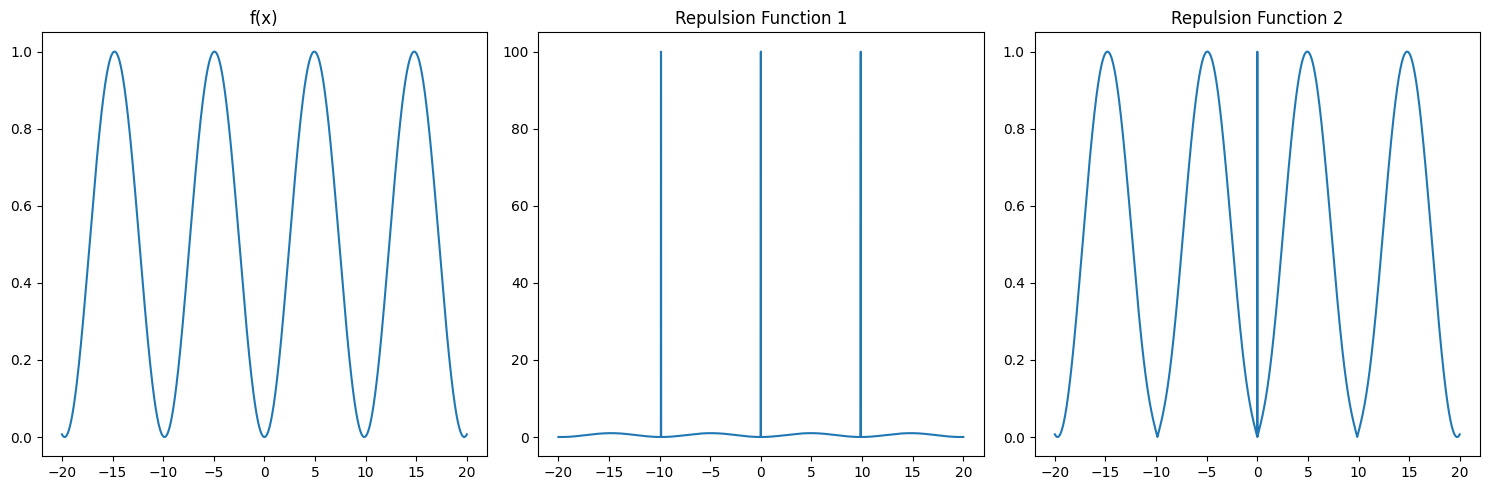

In [90]:
import matplotlib.pyplot as plt
import numpy as np

alpha = 1
epsilon = 1e-7
beta = 100
rho = 1e-2
root = np.array([0,np.pi**2,-np.pi**2])

x = np.linspace(-20, 20, 4001)

def f(x):
    return np.sin(x / np.pi) ** 2

def chi_p(delta_j, rho):
    """
    Characteristic Function
    """
    return 1 if delta_j <= rho else 0

def R1(x):
    """
    Repulsion Function
    """
    f_x = f(x)
    Rx = 0
    for x_star in root:
        delta_j = np.linalg.norm(x - x_star)
        Rx += np.exp(-delta_j) * chi_p(delta_j, rho)
    Rx *= beta
    Rx += f_x
    return Rx

def R2(x):
    """
    Repulsion Function
    """
    Rx = 1
    for x_star in root:
        delta_j = np.linalg.norm(x - x_star)+epsilon
        Rx *= np.abs(1/np.tanh(alpha*delta_j))
    Rx *= (f(x) + epsilon)
    print(Rx)
    return Rx

repulse1 = [R1(xi) for xi in x]
repulse2 = [R2(xi) for xi in x]

# Create subplots
fig, ax = plt.subplots(1, 3,figsize=(15, 5))

# Plot functions on subplots
ax[0].plot(x, f(x))
ax[0].set_title('f(x)')

ax[1].plot(x, repulse1)
ax[1].set_title('Repulsion Function 1')

ax[2].plot(x, repulse2)
ax[2].set_title('Repulsion Function 2')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()